In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


In [6]:

def gibbs_bayesA(X, X_f, y, num_iterations, nu_e, S_e, nu_j, S_j):
    n, p = X.shape
    q = X_f.shape[1]
    
    # 初始化参数
    beta_f = np.zeros(q)
    beta = np.zeros(p)
    sigma_e2 = 1.0
    sigma_j2 = np.ones(p)
    
    # 保存参数的采样值
    beta_f_samples = np.zeros((num_iterations, q))
    beta_samples = np.zeros((num_iterations, p))
    sigma_e2_samples = np.zeros(num_iterations)
    sigma_j2_samples = np.zeros((num_iterations, p))

    for it in range(num_iterations):
        # Step 1: 更新固定效应 beta_f
        X_fT_X_f = X_f.T @ X_f
        X_fT_y = X_f.T @ (y - X @ beta)
        beta_f_cov = np.linalg.inv(X_fT_X_f / sigma_e2)
        beta_f_mean = beta_f_cov @ X_fT_y / sigma_e2
        beta_f = np.random.multivariate_normal(beta_f_mean, beta_f_cov)
        
        # Step 2: 更新 SNP 标记效应 beta
        for j in range(p):
            X_j = X[:, j]
            y_adj = y - X_f @ beta_f - X @ beta + X_j * beta[j]
            beta_j_cov = 1 / (X_j.T @ X_j / sigma_e2 + 1 / sigma_j2[j])
            beta_j_mean = beta_j_cov * (X_j.T @ y_adj) / sigma_e2
            beta[j] = np.random.normal(beta_j_mean, np.sqrt(beta_j_cov))
        
        # Step 3: 更新残差方差 sigma_e2
        residual = y - X_f @ beta_f - X @ beta
        SS_residual = residual.T @ residual
        sigma_e2 = 1 / np.random.gamma((n + nu_e) / 2, 2 / (SS_residual + S_e))
        
        # Step 4: 更新 SNP 标记效应方差 sigma_j2
        for j in range(p):
            sigma_j2[j] = 1 / np.random.gamma((nu_j + 1) / 2, 2 / (nu_j * S_j + beta[j] ** 2))
        
        # 保存结果
        beta_f_samples[it, :] = beta_f
        beta_samples[it, :] = beta
        sigma_e2_samples[it] = sigma_e2
        sigma_j2_samples[it, :] = sigma_j2
    
    return beta_f_samples, beta_samples, sigma_e2_samples, sigma_j2_samples

def simulate_data(n_samples, n_fixed_effects, n_snps, true_sigma_e2=1.0):
    # 固定效应的设计矩阵 X_f 和 SNP 标记的设计矩阵 X
    X_f = np.random.randn(n_samples, n_fixed_effects)
    X = np.random.randn(n_samples, n_snps)
    
    # 真实的固定效应参数和 SNP 效应参数
    true_beta_f = np.random.randn(n_fixed_effects)
    true_beta = np.random.randn(n_snps) * np.random.binomial(1, 0.5, size=n_snps)  # Sparsity
    
    # 残差噪声
    epsilon = np.random.randn(n_samples) * np.sqrt(true_sigma_e2)
    
    # 生成表型 y
    y = X_f @ true_beta_f + X @ true_beta + epsilon
    
    return X_f, X, y, true_beta_f, true_beta



In [7]:
# 模拟数据
n_samples = 500
n_fixed_effects = 2
n_snps = 20
X_f, X, y, true_beta_f, true_beta = simulate_data(n_samples, n_fixed_effects, n_snps)

# 设置 Gibbs 采样参数
num_iterations = 1000
nu_e, S_e = 1, 1
nu_j, S_j = 1, 1

# 运行 Gibbs 采样
beta_f_samples, beta_samples, sigma_e2_samples, sigma_j2_samples = gibbs_bayesA(
    X, X_f, y, num_iterations, nu_e, S_e, nu_j, S_j)


In [8]:
# 计算参数的后验均值
estimated_beta_f = np.mean(beta_f_samples, axis=0)
estimated_beta = np.mean(beta_samples, axis=0)

# 打印比较结果
print("真实的固定效应参数: ", true_beta_f)
print("估计的固定效应参数: ", estimated_beta_f)

print("\n真实的SNP效应参数: ", true_beta)
print("估计的SNP效应参数: ", estimated_beta)


真实的固定效应参数:  [0.773444   0.91699129]
估计的固定效应参数:  [0.78559881 0.82568996]

真实的SNP效应参数(前10个):  [ 0.         -0.          0.         -0.         -0.50407722 -0.38100272
 -0.         -0.          1.26172196  1.05764662  0.11770422 -0.04293173
  0.97589548  0.          0.         -0.         -0.          0.
  0.         -0.        ]
估计的SNP效应参数(前10个):  [ 5.12273857e-03  1.27372040e-02  2.87647264e-02  4.15864180e-02
 -3.93211742e-01 -3.02582392e-01  4.20989796e-02  3.06139400e-02
  1.25090353e+00  1.10870309e+00  1.98669891e-01  6.55922553e-04
  9.75788951e-01 -1.24041401e-02  3.39665660e-02  7.60802800e-02
  3.19820057e-02  7.46050657e-02  7.45812076e-02  2.32382429e-02]


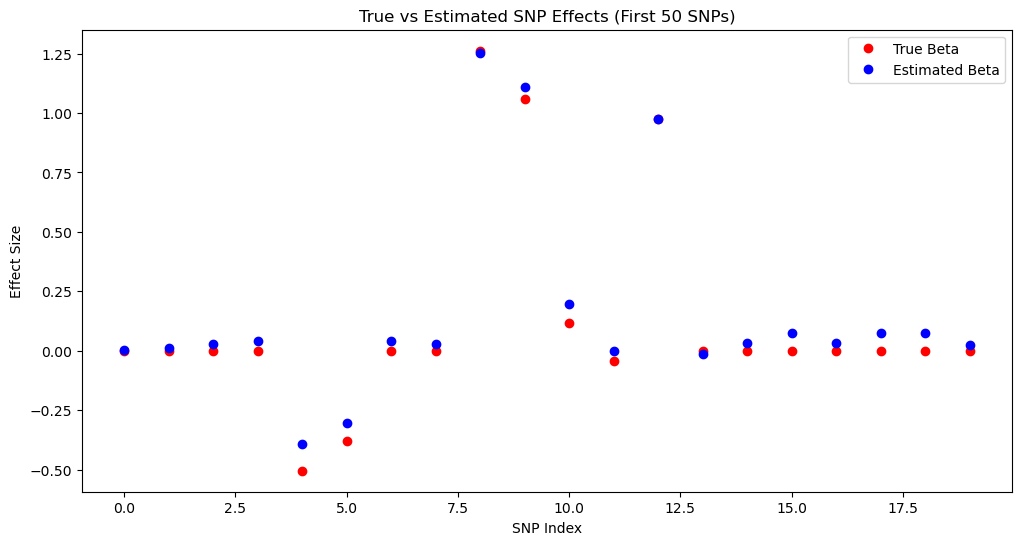

In [9]:
# 绘制真实和估计的 SNP 效应参数对比
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()
